#**Deep Learning Homework 3: Convolutional Neural Networks**
### MSc Computer Science, Data Science, Cybersecurity @UNIPD
### 2nd semester - 6 ECTS
### Prof. Alessandro Sperduti, Prof. Nicolò Navarin and Dr. Luca Pasa
---
In this homework, we will explore how to develop a simple Convolutional Neural Network for image classification. We will use the CIFAR-10 dataset. In the first part, we will learn how to develop a simple CNN, while in the second part we will explore the impact of various hyper-parameters on the learning performances.

# Requirements
Let's start importing the libraries we will need and setting a couple of environmental variables.

**Disclaimer**: the notebook has been tested in Colab with Python `3.9.16`. Some parts *may* not work as expected using different packages and Python versions.

In [1]:
print("You are using:")
!python --version


You are using:
Python 3.10.11


In [2]:
# They've just released torch 2.0, but we will use the more stable torch=1.13 along with other supporting libriaries
!pip3 install pandas~=1.5 torch~=1.13 torchinfo torchdata~=0.5 torchtext~=0.14 torchvision~=0.14 torchaudio~=0.13

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 92.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 96.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 93.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 110.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 61.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling 

In [3]:
import torch
from torch import nn
from torch.nn import Conv2d, MaxPool2d, Linear
from torchinfo import summary
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Lambda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore") #Conflict of nn.functional.act_f and torch.act_f

print(f"{torch.__version__=}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device=}")
!nvidia-smi --format=csv --query-gpu=index,name,driver_version,memory.total,memory.used,memory.free

# Set seed for reproducibility
torch.manual_seed(43)
rng = np.random.default_rng(seed=4242)

torch.__version__='1.13.1+cu117'
device=device(type='cuda')
index, name, driver_version, memory.total [MiB], memory.used [MiB], memory.free [MiB]
0, Tesla T4, 525.85.12, 15360 MiB, 3 MiB, 15098 MiB


# Exercise 3.1: Simple CNN

## Data Loading and Preprocessing [TO COMPLETE]


We will use the `CIFAR-10` dataset.The dataset consists of $60.000$ images in $10$ classes, with $6.000$ images per class. There are $50.000$ training images and $10.000$ test images. Each sample is a $32\times32$ pixels color image (thus with an extra $\times3$ dimensions for the colors channels), associated with a label from one of the classes:

```python
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
```

We will divide the dataset in training, testing and validation set. As you already know, the training set will be used to train the model, the validation set will be used to perform model selection and finally, the test set will be used to asses the performance of deep network.

**[TO COMPLETE]**

In the standard dataset, each pixel intensity is represented by a `uint8` (byte) from $0$ to $255$. As a preprocessing step, we will rescale these values in the range $[0,1]$. You should write a simple so-called MinMaxScaler which takes as input a PIL Image (a specific format for images in Python) and rescales it, after making the appropriate type and shape transformations.

`%STARTCODE`

In [4]:
def MinMaxScaler(img):#[TO COMPLETE]
  # First, we load the data as numpy array
  img_as_array = np.asarray(img)
  img_as_tensor=torch.from_numpy(img_as_array)# TO COMPLETE: Transform the array to Tensor for PyTorch
  #img=img_as_tensor.rand_like(img_as_tensor)
  #img[0]=img_as_tensor[2]
  #img[1]=img_as_tensor[0]
  #img[2]=img_as_tensor[1]
  img=img_as_tensor.permute((2,0,1))# TO COMPLETE: image is of size (Height, Width, Channels). But torch excepts (C, H, W). Hence, the second thing is to permute.
  normalized_img=img/255.# TO COMPLETE: Rescale image pixels form [0,255] to [0,1]
  return normalized_img


'''
NEW DATA LOADING
Note that the previous function must be passed to transforms.Lambda().
'''
dataset = CIFAR10(root='data/', download=True, train=True, transform=transforms.Lambda(MinMaxScaler)) # 50000 samples
test_data = CIFAR10(root='data/', download=True, train=False, transform=transforms.Lambda(MinMaxScaler)) # 10000 samples

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


`%ENDCODE`

In [5]:
# Let's check the classes and dataset shapes:
classes = dataset.classes
print(f"{classes=}")
print(f"Dataset shape: {dataset.data.shape}")
print(f"Test set shape: {test_data.data.shape}")

classes=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Dataset shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


In [6]:
dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Lambda()

In [7]:
# Let's also check whether the dataset is balanced, i.e. there are the same amount of samples for each class
label_count = {}
for _, idx in dataset:
    label = classes[idx]
    if label not in label_count:
        label_count[label] = 0
    label_count[label] += 1
label_count

{'frog': 5000,
 'truck': 5000,
 'deer': 5000,
 'automobile': 5000,
 'bird': 5000,
 'horse': 5000,
 'ship': 5000,
 'cat': 5000,
 'dog': 5000,
 'airplane': 5000}

We split the dataset into training/validation sets:

In [8]:
val_size = 5000
train_size = len(dataset) - val_size

train_data, val_data = random_split(dataset, [train_size, val_size])
print(f"Training samples = {len(train_data)} \nValidation samples = {len(val_data)} \nTest samples = {len(test_data)}")

Training samples = 45000 
Validation samples = 5000 
Test samples = 10000


Let's see how normalized sample looks like...

In [9]:
idx = 50 # 51st data sample
print(train_data[idx]) # (image, label) tensors
assert train_data[idx][0].max().item() <= 1., "Check your MinMaxScaler!"

(tensor([[[0.7373, 0.7216, 0.7255,  ..., 0.7922, 0.7922, 0.7882],
         [0.7216, 0.7059, 0.7137,  ..., 0.7765, 0.7725, 0.7725],
         [0.7373, 0.7255, 0.7216,  ..., 0.7569, 0.7529, 0.7490],
         ...,
         [0.7608, 0.7608, 0.7647,  ..., 0.7647, 0.7765, 0.7686],
         [0.8039, 0.8000, 0.8039,  ..., 0.8157, 0.8157, 0.8000],
         [0.8235, 0.8157, 0.8157,  ..., 0.7922, 0.8000, 0.7804]],

        [[0.6902, 0.6784, 0.6824,  ..., 0.7490, 0.7490, 0.7451],
         [0.6784, 0.6627, 0.6706,  ..., 0.7333, 0.7294, 0.7294],
         [0.6941, 0.6824, 0.6784,  ..., 0.7137, 0.7098, 0.7059],
         ...,
         [0.7137, 0.7098, 0.7137,  ..., 0.7137, 0.7255, 0.7176],
         [0.7569, 0.7569, 0.7608,  ..., 0.7725, 0.7725, 0.7569],
         [0.7804, 0.7725, 0.7725,  ..., 0.7490, 0.7569, 0.7373]],

        [[0.6745, 0.6627, 0.6667,  ..., 0.7333, 0.7333, 0.7294],
         [0.6588, 0.6471, 0.6549,  ..., 0.7176, 0.7137, 0.7137],
         [0.6784, 0.6667, 0.6627,  ..., 0.6980, 0.6941, 0

... it's better to see it as images!

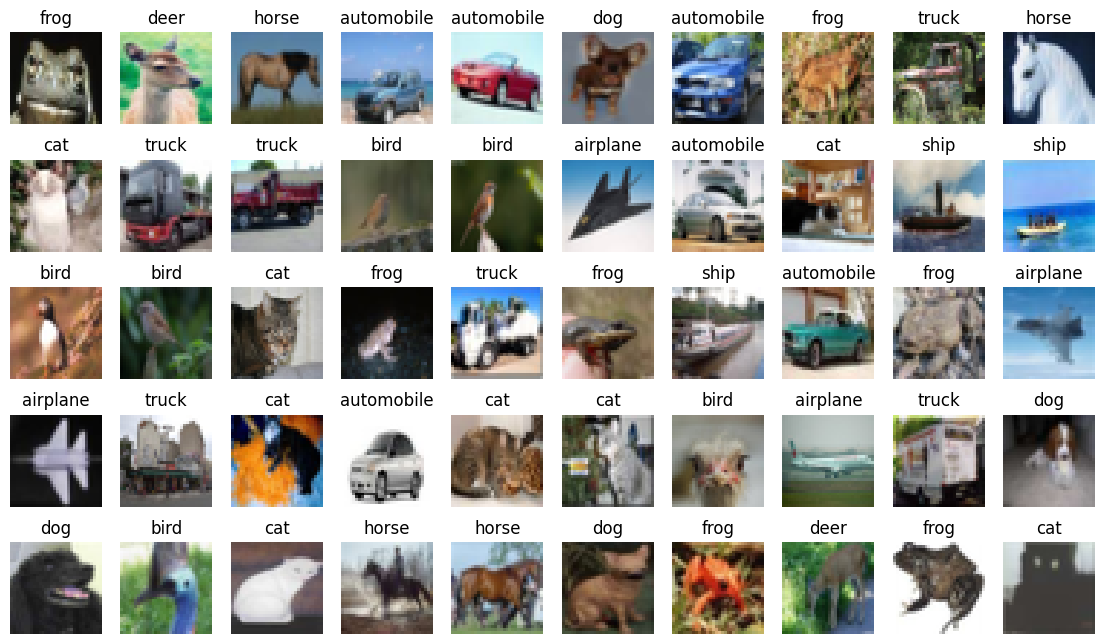

In [10]:
img_chan, img_height, img_width = train_data[idx][0].shape #Channel, Height, Width
#print("chan= ",img_chan,"height= ", img_height,"img_width= ",img_width)
# Plots
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        image, label = train_data[index]
        image = image.permute((1, 2, 0)) #C,H,W -> H,W,C
        plt.imshow(image, cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(classes[label])
plt.show()

Explain in the cell below when using Gradient Descent, why it is usually a good idea to ensure that all the features have a similar scale. 

`%STARTEXT`

Answer:It is a good idea to ensure that all the features have a similar scale in order to reduce bias and make sure that the algorithm doesn't treat features differently based on their respective scales of representation. We want to make sure that the trained model doesn't assign higher weights to feature values with a bigger scale  **[TO COMPLETE]**

`%ENDTEXT`

Since `train_data`, `val_data` and `test_data` are already PyTorch Datasets, we can use directly DataLoaders to load data from them.

In [11]:
batch_size = 256
dataloader_training = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloader_validation = DataLoader(val_data, batch_size=batch_size)
dataloader_test = DataLoader(test_data, batch_size=batch_size)

##Model Definition and Training

Let's create a simple CNN. The model will be composed of:
* One 2D convolutional layer with kernel size 3x3 and 32 output filters/features, that use ReLU activation function
* a Max Pooling layer (2D) of size 2x2.
* a Flatten layer
* a final Dense layer with 10 output neurons (one per class). We do not need to normalize or transform further the outputs, as the `CrossEntropyLoss` takes care of that. Another equivalent approach would be to add a `LogSoftmax` final layer that returns log-probabilities and then use the `NegativeLogLikelihoodLoss`., and with the _softmax_ activation function to ensure that the sum of all the estimated class probabilities for each image is equal to 1.
Note that as `input_shape` attribute's value in the first layer report also the third dimension that represents the channel.

In [12]:
class My_Convolutional_Network(nn.Module):
  def __init__(self, conv_filters=[], kernel_sizes=[], max_pool_sizes=[], act_fs=[], verbose=False):
    super().__init__()

    assert len(conv_filters) == len(kernel_sizes), "length of {conv_filters} and {kernel_sizes} must be same"
    assert len(conv_filters) == len(max_pool_sizes), "length of {conv_filters} and {max_pool_sizes} must be same"
    # max pool of [1, 1] corresponds to no max pool
    assert len(conv_filters) == len(act_fs), "length of {conv_filters} and {act_fs} must be same"

    self.conv_layers = nn.ModuleList()
    self.max_pools = nn.ModuleList()
    self.in_chan = img_chan
    self.in_height = img_height
    self.in_width = img_width
    self.output_dim = len(classes)#10
    self.verbose = verbose
    self.act_fs = act_fs

    height_dimension = self.in_height
    width_dimension = self.in_width

    for maxp1, maxp2 in max_pool_sizes: # as long as padding='same'
      height_dimension = height_dimension // maxp1
      width_dimension = width_dimension // maxp2

    self.inp_dim_to_linear = conv_filters[-1] * height_dimension * width_dimension

    for idx in range(len(conv_filters)):
      if idx == 0:
        #Conv2d(in_channels, out_channels, kernel_size, padding)
        self.conv_layers = self.conv_layers.append(Conv2d(self.in_chan, conv_filters[idx],
                                                          kernel_sizes[idx], padding='same'))
      else:
        self.conv_layers = self.conv_layers.append(Conv2d(conv_filters[idx-1], conv_filters[idx],
                                                          kernel_sizes[idx], padding='same'))
        
      self.max_pools = self.max_pools.append(MaxPool2d(max_pool_sizes[idx]))
    
    self.linear = Linear(self.inp_dim_to_linear, self.output_dim)

  def forward(self, x):

    for idx in range(len(self.conv_layers)):
      from_shape = x.shape[1:]
      active_conv_layer = self.conv_layers[idx]
      active_max_pool = self.max_pools[idx]
      active_act_fun = self.act_fs[idx]
      x = active_max_pool(active_act_fun(active_conv_layer(x)))
      to_shape = x.shape[1:]

      if self.verbose:
        print(f'From dimension [{from_shape}] to dimension [{to_shape}]')

    x = torch.flatten(x, start_dim=1) #if start_dim=1 missed, it also consider batch_size

    if self.verbose:
        print(f'From dimension [{to_shape}] to dimension [{x.shape[1:]}]')
        print(f'From dimension [{x.shape[1:]}] to dimension [{self.output_dim}]')

    return self.linear(x) #no need to use softmax because of the loss function

In [13]:
conv_filters = [32]
kernel_sizes = [[3, 3]]
max_pool_sizes = [[2, 2]]
act_fs = [F.relu]

num_epochs = 20
lr = 1e-3
model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                 act_fs, False).to(device)
summary(model, input_size=(batch_size, 3, 32, 32)) # Here is a nice summary of our model!

Layer (type:depth-idx)                   Output Shape              Param #
My_Convolutional_Network                 [256, 10]                 --
├─ModuleList: 1-1                        --                        --
│    └─Conv2d: 2-1                       [256, 32, 32, 32]         896
├─ModuleList: 1-2                        --                        --
│    └─MaxPool2d: 2-2                    [256, 32, 16, 16]         --
├─Linear: 1-3                            [256, 10]                 81,930
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
Total mult-adds (M): 255.86
Input size (MB): 3.15
Forward/backward pass size (MB): 67.13
Params size (MB): 0.33
Estimated Total Size (MB): 70.61

Note that the number of parameters mostly depends on the output layers, indeed the parameter sharing techinique used by the 2D convolutional layers allows to significantly reduce the number of learnable weights.
Now we can train the model.

In [14]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [15]:
def train(model, optimizer, dataloader_train, dataloader_val, epochs):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(epochs):

    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (img, label) in enumerate(dataloader_train):
      img, label = img.to(device), label.to(device)
      optimizer.zero_grad()
      logits = model(img)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      total_acc_train += (logits.argmax(1) == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)
    
    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (img, label) in enumerate(dataloader_val):
            img, label = img.to(device), label.to(device)
            logits = model(img)
            loss = criterion(logits, label)
            total_loss_val += loss
            total_acc_val += (logits.argmax(1) == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val) 
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

In [16]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 40.41%, Loss: 1.70189154 ---------------- Val_Acc: 48.26%, Val_Loss: 1.51178586
epoch: 2 -> Accuracy: 51.80%, Loss: 1.39580381 ---------------- Val_Acc: 52.28%, Val_Loss: 1.37457955
epoch: 3 -> Accuracy: 55.87%, Loss: 1.28210211 ---------------- Val_Acc: 54.42%, Val_Loss: 1.30326486
epoch: 4 -> Accuracy: 58.36%, Loss: 1.20809805 ---------------- Val_Acc: 56.86%, Val_Loss: 1.23926914
epoch: 5 -> Accuracy: 60.32%, Loss: 1.15330827 ---------------- Val_Acc: 56.30%, Val_Loss: 1.23736084
epoch: 6 -> Accuracy: 61.80%, Loss: 1.11143231 ---------------- Val_Acc: 58.22%, Val_Loss: 1.18768895
epoch: 7 -> Accuracy: 62.85%, Loss: 1.07727242 ---------------- Val_Acc: 59.14%, Val_Loss: 1.16229224
epoch: 8 -> Accuracy: 63.97%, Loss: 1.05207264 ---------------- Val_Acc: 60.12%, Val_Loss: 1.15752733
epoch: 9 -> Accuracy: 64.73%, Loss: 1.02737272 ---------------- Val_Acc: 60.68%, Val_Loss: 1.14112973
epoch: 10 -> Accuracy: 65.75%, Loss: 1.00160789 ---------------- Val_Acc: 59.82%, 

In [17]:
def plot_learning_acc_and_loss(loss_tr, acc_tr, loss_val, acc_val):

    plt.figure(figsize=(8, 10))

    plt.subplot(2, 1, 1)
    plt.grid()
    plt.plot(range(num_epochs), acc_tr, label='acc_training')
    plt.plot(range(num_epochs), acc_val, label='acc_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.grid()
    plt.plot(range(num_epochs), loss_tr, label='loss_training')
    plt.plot(range(num_epochs), loss_val, label='loss_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

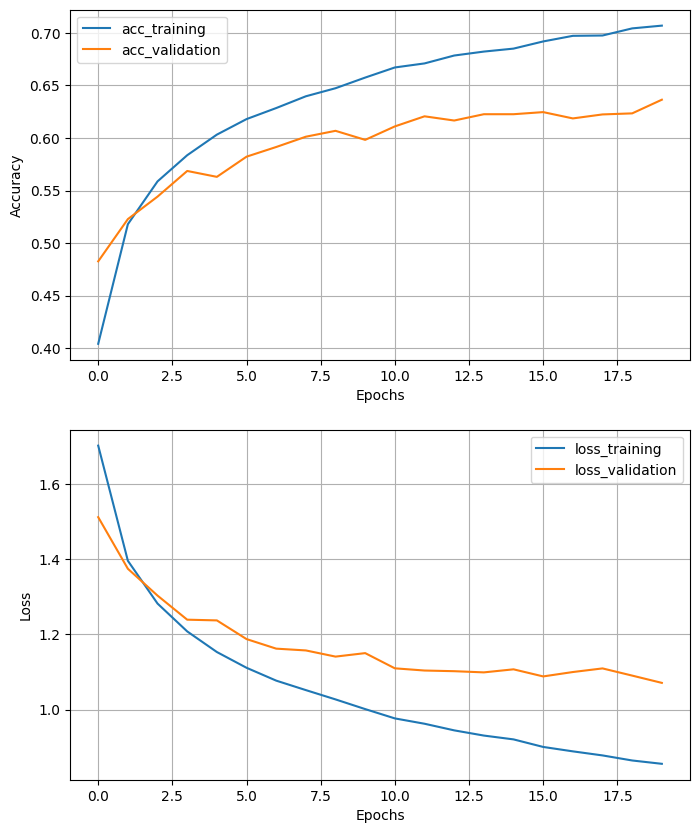

In [18]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

Finally, we test the model:

In [19]:
def test(model, dataloader_test=dataloader_test):
  model.eval()
  total_acc_test, total_count_test, n_batches_test, loss = 0, 0, 0, 0
  for idx, (img, label) in enumerate(dataloader_test):
      img, label = img.to(device), label.to(device)
      logits = model(img)
      loss += criterion(logits, label)
      total_acc_test += (logits.argmax(1) == label).sum().item()
      total_count_test += label.size(0)
      n_batches_test += 1
  accuracy_test = total_acc_test/total_count_test
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
  print(f"Test Accuracy: {100*accuracy_test:.4f}%")

In [20]:
test(model)

Test Loss: 1.05089569 ---------- Test Accuracy: 63.8300%


Here we see that the test accuracy of our simple CNN is about 64%.

## Visualize filters
Let's now visualize the filters emerged in the first convolutional layer.

In [21]:
layer_names = []
weights = {}
for name, param in model.named_parameters():
    if param.requires_grad:
        layer_names.append(name)
        weights.setdefault(name, param.data)

conv_weights = weights['conv_layers.0.weight']
print(f"{conv_weights.shape=} <=> [out_dim, inp_dim, kernel_size[0], kernel_size[1]]")

conv_weights.shape=torch.Size([32, 3, 3, 3]) <=> [out_dim, inp_dim, kernel_size[0], kernel_size[1]]


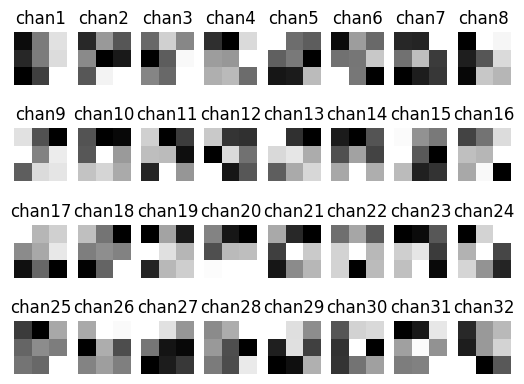

In [22]:
conv_w0 = conv_weights[:, 0, :, :] # Pick one input dimension

# Rescale weights for visualization
conv_w0 -= torch.min(conv_w0)
conv_w0 /= torch.max(conv_w0)

for r in range(4):
    for c in range(8):
        n=r*8+c
        plt.subplot(4, 8, n+1)
        plt.imshow(conv_w0[n,:,:].cpu(), interpolation='none')
        plt.title(f'chan{n+1}')
        plt.axis('off')
        plt.gray()
plt.show()

They might be a bit hard to interpret, but it seems that the various filters have learned to detect various corners and edges.

## Parameters of a CNN [TO COMPLETE]

Explain in the cell below:

1. How are the number of parameters for Conv2D layers are determined? Perform the calculations to calculate the parameters of the Conv2D layer. 

`%STARTEXT`

Answer1 : The number of parameters of the conv2D layer is determined by the product between the number of filters and the size of the kernels = 32$*$3$*$3= 288  **[TO COMPLETE]**



`%ENDTEXT`

# Exercise 3.2: Deep CNN


Let's consider a deeper model, more precisly in this exercise we consider a model composed of:
* One 2D convolutional layer with kernel size 3x3 and 32 output filters/features, that use ReLu activation function
* a Max Pooling layer (2D) of size 2x2 
* One 2D convolutional layer with kernel size 2x2 and 16 output filters/features, that use ReLu activation function
* a Max Pooling layer (2D) of size 2x2
* a Flatten layer
* a final Dense layer with 10 output neurons (one per class), and with the _softmax_ activation function


In [23]:
conv_filters = [32, 16]
kernel_sizes = [[3, 3], [2, 2]]
max_pool_sizes = [[2, 2], [2, 2]]
act_fs = [F.relu, F.relu]

num_epochs = 20
lr = 1e-3
deep_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
summary(deep_model, input_size=(batch_size, 3, 32, 32)) # Here is a nice summary of our model!

Layer (type:depth-idx)                   Output Shape              Param #
My_Convolutional_Network                 [256, 10]                 --
├─ModuleList: 1-3                        --                        (recursive)
│    └─Conv2d: 2-1                       [256, 32, 32, 32]         896
├─ModuleList: 1-4                        --                        --
│    └─MaxPool2d: 2-2                    [256, 32, 16, 16]         --
├─ModuleList: 1-3                        --                        (recursive)
│    └─Conv2d: 2-3                       [256, 16, 16, 16]         2,064
├─ModuleList: 1-4                        --                        --
│    └─MaxPool2d: 2-4                    [256, 16, 8, 8]           --
├─Linear: 1-5                            [256, 10]                 10,250
Total params: 13,210
Trainable params: 13,210
Non-trainable params: 0
Total mult-adds (M): 372.77
Input size (MB): 3.15
Forward/backward pass size (MB): 75.52
Params size (MB): 0.05
Estimated Total S

In [24]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(deep_model.parameters(), lr=lr)

In [25]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(deep_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 34.72%, Loss: 1.84355533 ---------------- Val_Acc: 41.68%, Val_Loss: 1.64494920
epoch: 2 -> Accuracy: 45.68%, Loss: 1.54026163 ---------------- Val_Acc: 47.18%, Val_Loss: 1.48344219
epoch: 3 -> Accuracy: 50.17%, Loss: 1.40908623 ---------------- Val_Acc: 50.86%, Val_Loss: 1.39868772
epoch: 4 -> Accuracy: 52.45%, Loss: 1.34142947 ---------------- Val_Acc: 52.22%, Val_Loss: 1.34495008
epoch: 5 -> Accuracy: 54.52%, Loss: 1.29071701 ---------------- Val_Acc: 53.96%, Val_Loss: 1.30400395
epoch: 6 -> Accuracy: 55.95%, Loss: 1.25782931 ---------------- Val_Acc: 55.20%, Val_Loss: 1.27978897
epoch: 7 -> Accuracy: 56.87%, Loss: 1.23034608 ---------------- Val_Acc: 55.10%, Val_Loss: 1.26563942
epoch: 8 -> Accuracy: 57.70%, Loss: 1.20305049 ---------------- Val_Acc: 56.66%, Val_Loss: 1.23301160
epoch: 9 -> Accuracy: 58.90%, Loss: 1.17366970 ---------------- Val_Acc: 57.24%, Val_Loss: 1.21660781
epoch: 10 -> Accuracy: 59.36%, Loss: 1.15997243 ---------------- Val_Acc: 56.08%, 

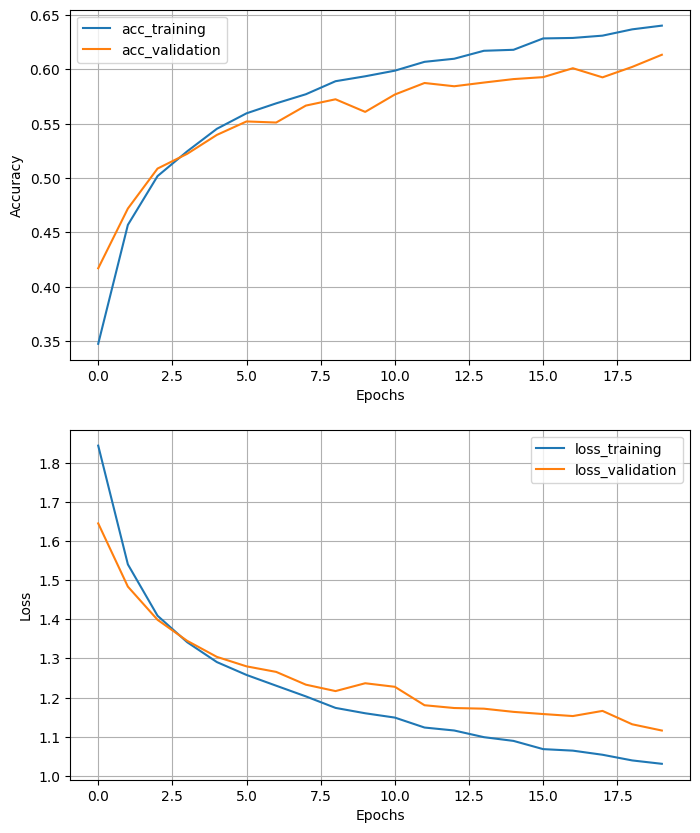

In [26]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [27]:
test(deep_model)

Test Loss: 1.07134318 ---------- Test Accuracy: 62.5200%


Whoa! By developing the deep CNN we dropped the accuracy fom ~64% to ~62%. It seems like we need to develop a better CNN model. 

# Exercise 3.3: A better CNN [TO COMPLETE]

Let's develop a network that performs better than the very simple one above. This exercise aims to explore how much the various hyper-parameters influence the classification capability of the model. 

**[TO COMPLETE]**: Your task is to modify some of the hyper-parameters of the previous exercise's network and compare the results. At least one of the models you try should have an improvement in the test set results (generalization) over the result of the model used in the previous exercise.
In the cell below report only the code of the **best model** that you can find. In addtion, print out its result on the test set, and plot the accuracy and the loss trends in the notebook you return.
Moreover, for each setup you test, analyze and discuss the obtained results briefly in the last cells at the bottom.

Hint: Each reparameterization should change a different aspect in the network, while the rest of the parameters would stay the same. 
Example parameters to try to change (we suggest to test at least one re-parametrization for each of these categories):

*    number of layers or neurons or filters dimension
*   activation functions
*   epochs
*   batch sizes
*   max-pooling on/off on certain layers, or pool size

`%STARTCODE`

My_Convolutional_Network(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (max_pools): ModuleList(
    (0): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (1): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
epoch: 1 -> Accuracy: 39.18%, Loss: 1.72098565 ---------------- Val_Acc: 47.56%, Val_Loss: 1.49539113
epoch: 2 -> Accuracy: 50.69%, Loss: 1.40168953 ---------------- Val_Acc: 52.58%, Val_Loss: 1.34975183
epoch: 3 -> Accuracy: 55.24%, Loss: 1.27833688 ---------------- Val_Acc: 55.24%, Val_Loss: 1.26996267
epoch: 4 -> Accuracy: 57.58%, Loss: 1.20880175 ---------------- Val_Acc: 56.86%, Val_Loss: 1.21723998
epoch: 5 -> Accuracy: 60.20%, Loss: 1.14557421 ---------------- Val_Acc: 58.50%, Val_Loss: 1.17551386


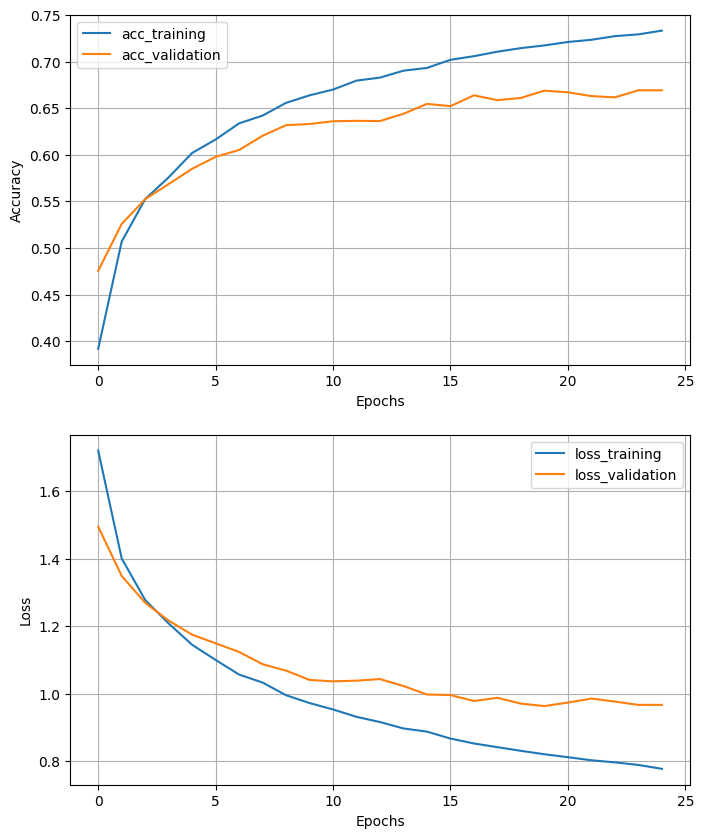

Test Loss: 0.93212050 ---------- Test Accuracy: 67.8400%


In [28]:
# TO COMPLETE
conv_filters = [32, 32]
kernel_sizes = [[3, 3], [3, 3]]
max_pool_sizes = [[2, 2], [2, 2]]
act_fs = [F.relu, F.relu]

num_epochs = 25
lr = 1e-3
new_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
                                    
#summary(new_model, input_size=(batch_size, 3, 32, 32))

print(new_model)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(new_model.parameters(), lr=lr)

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(new_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

test(new_model)


`%ENDCODE`

# [TO COMPLETE] Discuss your results

In the discussion, you need to clearly motivate your choice of hyperparameters, what work and what did not work. 
You also need to plot all the results of experiments you have conducted. 

`%STARTEXT`

The best model that I found is: 

My_Convolutional_Network(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (max_pools): ModuleList(
    (0): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (1): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Linear(in_features=8192, out_features=10, bias=True)
)


 **[TO COMPLETE]**

The achieved accuracy in the test set is 67.84% **[TO COMPLETE]**

Discussion:
I first increased the number of filters in the second convolutional layer to 32 (the same as the the first conv layer), and reduced the pool size of the first layer to [1,1], to increase the overall number of parameters to be trained. As the input of the second conv layer is still 32 , i increased the filter size of the kernel to [3,3] even in the second layer. The second maxpool layer reduces the input size of the image to 16x16, mapping 32x16x16 values to 10 classes. From the graph the difference between the the validation and training accuracies clearly indicated that the model was overfitting but it still was the model that gave me the highest test accuracy of 66,5% at the time. So i knew i was on the right path but i wanted to reduce the effect of overfitting. So i reset the max_pool_size=[[2,2],[2,2]] in order to reduce the overall number of inputs to the final linear function to 32x8x8 consequentially reducing the overfitting and slightly increasing the test accuracy to 67.22%. Since i previously noticed that increasing the number of epochs had a positive effect on the test accuracy, i increased the number of epochs to 25 and found a test accuracy of 67.84%
**[TO COMPLETE]**

Besides, I tested also other models: 
* Same model as EX 3.2 but with sigmoid activation functions 
```
act_fs = [F.sigmoid, F.sigmoid]
```
 Test_accuracy= 49.3% and Test_loss= 1.41157675.

* Same model as Ex 3.2 but with:
 ```
kernel_sizes=[[3,3],[3,3]]
conv_filters=[16,16]
```   
Test_Accuracy=63.07% and test_loss= 1.05811810

* Same model as Ex 3.2 but with increased number of epochs 
```
num_epochs=25
```   
Test_accuracy=64.09% and test_loss=1.0321898

* Same model as EX 3.2 but with with reduced number of conv filters and pool sizes 
```
conv_filters = [16, 16]
max_pool_sizes = [[2, 2], [1, 1]]
```
Test Accuracy: 63.15% and Test Loss: 1.07415414  
* Same model as EX 3.2 but with with reduced pool size in the first layer 
```
max_pool_sizes = [[1, 1], [2, 2]]
```
Test Accuracy: 63.89% and Test Loss: 1.06004679 

* Same model as EX 3.2 but with reduce number of filters and kernel sizes
```
conv_filters = [16, 10]
kernel_sizes = [[2, 2], [2, 2]]
```
Test Accuracy: 57.95% Test Loss: 1.20960975 
**[TO COMPLETE]**
* (SECOND BEST ACCURACY MODEL) Same model as EX 3.2 but with  increased number of conv filters and kernel size in the second layer with reduced pool size in the first layer
```
conv_filters = [32, 32]
kernel_sizes = [[3, 3], [3, 3]]
max_pool_sizes=[[1,1],[2,2]]
```
Test Accuracy: 66.5% and Test Loss: 1.05120742

* Same model as EX 3.2 but with  increased number of conv filters and kernel size in the second layer with reduced pool size in the first layer
```
conv_filters = [32, 32]
kernel_sizes = [[3, 3], [3, 3]]
max_pool_sizes=[[2,2],[4,4]]
```
Test Accuracy:65.48% , Test Loss: 1.00924551


Discussion: In the previous text block, i explained my reasoning for how i eventually found the best model i could find. Before that i tested the various models i just mentioned by modifying one or 2 hyperparameters of each kind. Modifying the activation function to a sigmoid function severely decreased the test accuracy, so i kept the original relu function. I then tried decreasing the number of filters of the first layer to 16 , no change in the test accuracy was found. So i then increased the kernel size of the second layer to [3,3] and i noticed a slight increase in test accuracy (around 63%). I then focused on other hyper parameters , i increased the number of epochs to 25 and i noticed a 2% increase in the test accuracy. I tried decreasing both the kernel sizes([2,2],[2,2] and number of filters([16,10]) and i noticed a significant decrease in the accuracy. So i went the other route, and i increased the number of filters to 32 for both layers and i noticed a good increase of 3%. I then tried modifying the pool sizes in addition to keeping the number of conv filters to 32 for both layers. I tested various values for the pool size of each layer which led me to end up with the best model i could find as i explained in the previous discussion section. 

Down below you can find the code for some of the models i tested
**[TO COMPLETE]**

My_Convolutional_Network(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Conv2d(32, 16, kernel_size=(2, 2), stride=(1, 1), padding=same)
  )
  (max_pools): ModuleList(
    (0): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (1): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Linear(in_features=1024, out_features=10, bias=True)
)
epoch: 1 -> Accuracy: 15.38%, Loss: 2.25302005 ---------------- Val_Acc: 25.56%, Val_Loss: 2.08478260
epoch: 2 -> Accuracy: 29.22%, Loss: 1.99646068 ---------------- Val_Acc: 32.20%, Val_Loss: 1.95001149
epoch: 3 -> Accuracy: 33.54%, Loss: 1.89666021 ---------------- Val_Acc: 34.36%, Val_Loss: 1.86517942
epoch: 4 -> Accuracy: 36.44%, Loss: 1.80925739 ---------------- Val_Acc: 35.22%, Val_Loss: 1.80931568
epoch: 5 -> Accuracy: 38.91%, Loss: 1.74214816 ---------------- Val_Acc: 38.28%, Val_Loss: 1.74809873


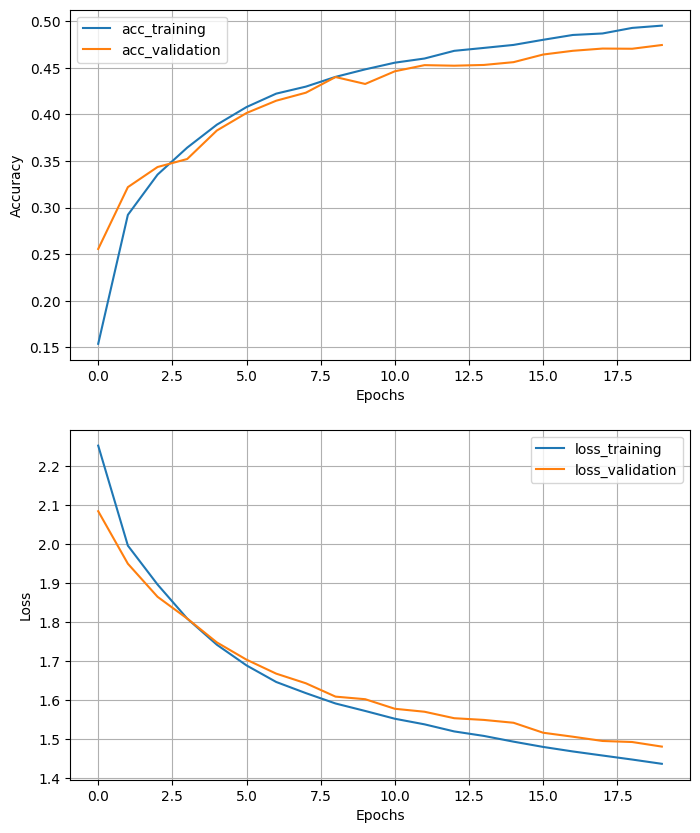

Test Loss: 1.43832648 ---------- Test Accuracy: 49.1600%


In [29]:
conv_filters = [32, 16]
kernel_sizes = [[3, 3], [2, 2]]
max_pool_sizes = [[2, 2], [2, 2]]
act_fs = [F.sigmoid, F.sigmoid]

num_epochs = 20
lr = 1e-3
new_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
                                    
#summary(new_model, input_size=(batch_size, 3, 32, 32))

print(new_model)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(new_model.parameters(), lr=lr)

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(new_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

test(new_model)

My_Convolutional_Network(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Conv2d(32, 16, kernel_size=(2, 2), stride=(1, 1), padding=same)
  )
  (max_pools): ModuleList(
    (0): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (1): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Linear(in_features=1024, out_features=10, bias=True)
)
epoch: 1 -> Accuracy: 33.27%, Loss: 1.87905562 ---------------- Val_Acc: 40.06%, Val_Loss: 1.68029594
epoch: 2 -> Accuracy: 44.54%, Loss: 1.56807554 ---------------- Val_Acc: 46.24%, Val_Loss: 1.52652335
epoch: 3 -> Accuracy: 48.83%, Loss: 1.45507002 ---------------- Val_Acc: 49.42%, Val_Loss: 1.43926752
epoch: 4 -> Accuracy: 52.08%, Loss: 1.36899555 ---------------- Val_Acc: 51.96%, Val_Loss: 1.37490737
epoch: 5 -> Accuracy: 54.25%, Loss: 1.30774724 ---------------- Val_Acc: 53.24%, Val_Loss: 1.32450342


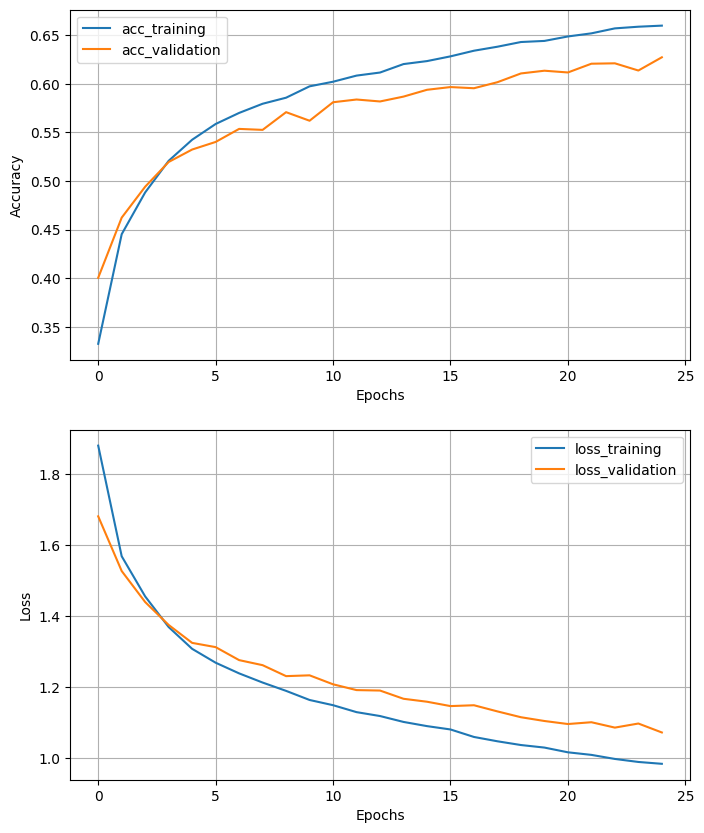

Test Loss: 1.04844224 ---------- Test Accuracy: 63.3800%


In [30]:
conv_filters = [32, 16]
kernel_sizes = [[3, 3], [2, 2]]
max_pool_sizes = [[2, 2], [2, 2]]
act_fs = [F.relu, F.relu]

num_epochs = 25
lr = 1e-3
new_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
                                    
#summary(new_model, input_size=(batch_size, 3, 32, 32))

print(new_model)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(new_model.parameters(), lr=lr)

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(new_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

test(new_model)

My_Convolutional_Network(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Conv2d(16, 16, kernel_size=(2, 2), stride=(1, 1), padding=same)
  )
  (max_pools): ModuleList(
    (0): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (1): MaxPool2d(kernel_size=[1, 1], stride=[1, 1], padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Linear(in_features=4096, out_features=10, bias=True)
)
epoch: 1 -> Accuracy: 34.51%, Loss: 1.84697533 ---------------- Val_Acc: 44.52%, Val_Loss: 1.59055066
epoch: 2 -> Accuracy: 48.40%, Loss: 1.46689379 ---------------- Val_Acc: 49.74%, Val_Loss: 1.42297626
epoch: 3 -> Accuracy: 52.42%, Loss: 1.35030544 ---------------- Val_Acc: 52.10%, Val_Loss: 1.35474312
epoch: 4 -> Accuracy: 54.94%, Loss: 1.28493524 ---------------- Val_Acc: 54.06%, Val_Loss: 1.30089998
epoch: 5 -> Accuracy: 56.27%, Loss: 1.24743497 ---------------- Val_Acc: 55.00%, Val_Loss: 1.27680361


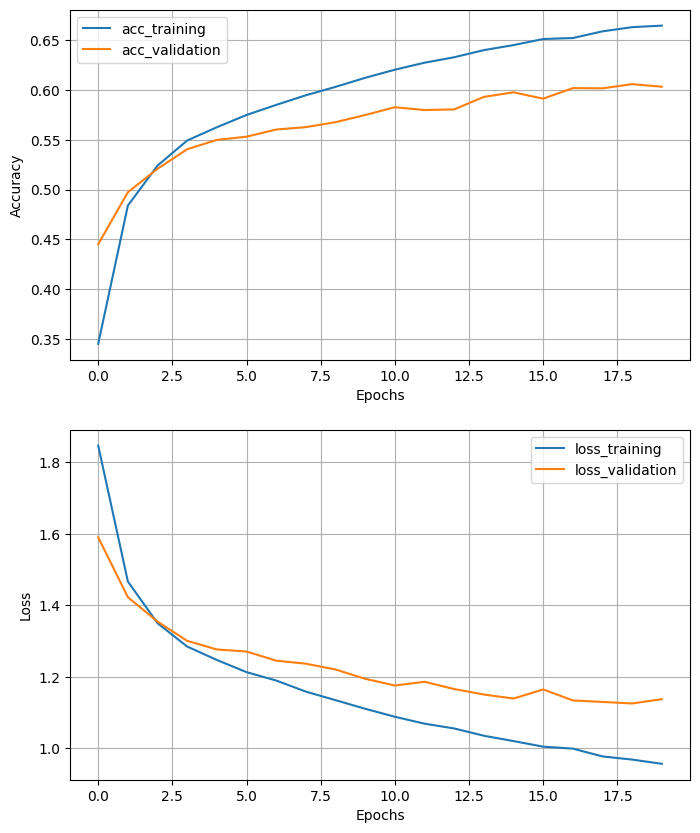

Test Loss: 1.10295665 ---------- Test Accuracy: 61.8800%


In [31]:
conv_filters = [16, 16]
kernel_sizes = [[3, 3], [2, 2]]
max_pool_sizes = [[2, 2], [1, 1]]
act_fs = [F.relu, F.relu]

num_epochs = 20
lr = 1e-3
new_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
                                    
#summary(new_model, input_size=(batch_size, 3, 32, 32))

print(new_model)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(new_model.parameters(), lr=lr)

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(new_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

test(new_model)

My_Convolutional_Network(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Conv2d(32, 16, kernel_size=(2, 2), stride=(1, 1), padding=same)
  )
  (max_pools): ModuleList(
    (0): MaxPool2d(kernel_size=[1, 1], stride=[1, 1], padding=0, dilation=1, ceil_mode=False)
    (1): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Linear(in_features=4096, out_features=10, bias=True)
)
epoch: 1 -> Accuracy: 39.34%, Loss: 1.71496236 ---------------- Val_Acc: 46.30%, Val_Loss: 1.50567257
epoch: 2 -> Accuracy: 51.66%, Loss: 1.37285900 ---------------- Val_Acc: 52.42%, Val_Loss: 1.34073436
epoch: 3 -> Accuracy: 56.13%, Loss: 1.24846816 ---------------- Val_Acc: 54.70%, Val_Loss: 1.28307211
epoch: 4 -> Accuracy: 58.88%, Loss: 1.17801917 ---------------- Val_Acc: 56.48%, Val_Loss: 1.24109733
epoch: 5 -> Accuracy: 60.41%, Loss: 1.13136077 ---------------- Val_Acc: 57.78%, Val_Loss: 1.19847322


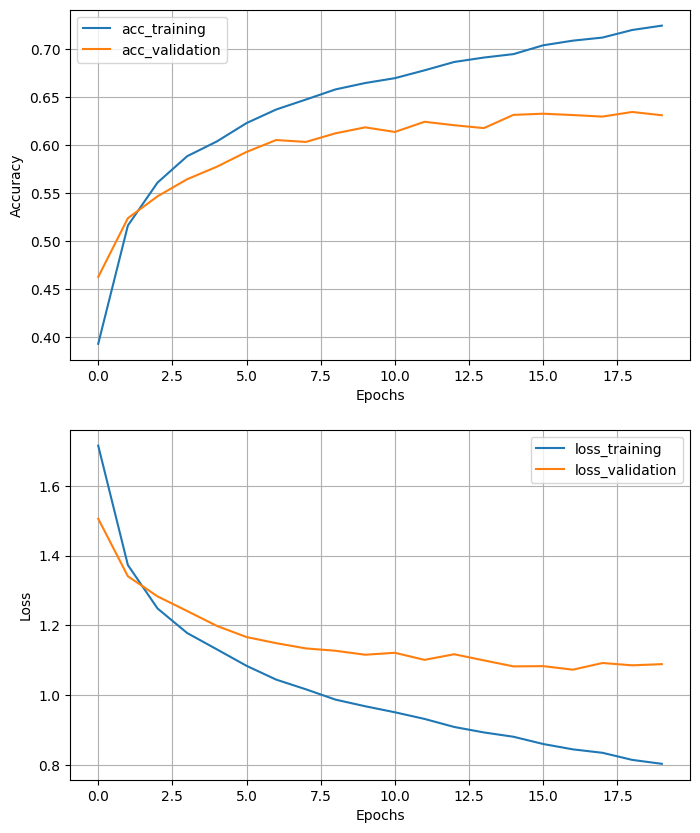

Test Loss: 1.05116510 ---------- Test Accuracy: 63.7800%


In [32]:
conv_filters = [32, 16]
kernel_sizes = [[3, 3], [2, 2]]
max_pool_sizes = [[1, 1], [2, 2]]
act_fs = [F.relu, F.relu]

num_epochs = 20
lr = 1e-3
new_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
                                    
#summary(new_model, input_size=(batch_size, 3, 32, 32))

print(new_model)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(new_model.parameters(), lr=lr)

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(new_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

test(new_model)

My_Convolutional_Network(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (max_pools): ModuleList(
    (0): MaxPool2d(kernel_size=[1, 1], stride=[1, 1], padding=0, dilation=1, ceil_mode=False)
    (1): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Linear(in_features=8192, out_features=10, bias=True)
)
epoch: 1 -> Accuracy: 42.84%, Loss: 1.62310374 ---------------- Val_Acc: 52.04%, Val_Loss: 1.37264121
epoch: 2 -> Accuracy: 56.46%, Loss: 1.24515748 ---------------- Val_Acc: 56.44%, Val_Loss: 1.23283470
epoch: 3 -> Accuracy: 60.97%, Loss: 1.12256908 ---------------- Val_Acc: 59.74%, Val_Loss: 1.14974463
epoch: 4 -> Accuracy: 64.15%, Loss: 1.03396571 ---------------- Val_Acc: 61.14%, Val_Loss: 1.11676240
epoch: 5 -> Accuracy: 66.44%, Loss: 0.96891683 ---------------- Val_Acc: 63.10%, Val_Loss: 1.06686962


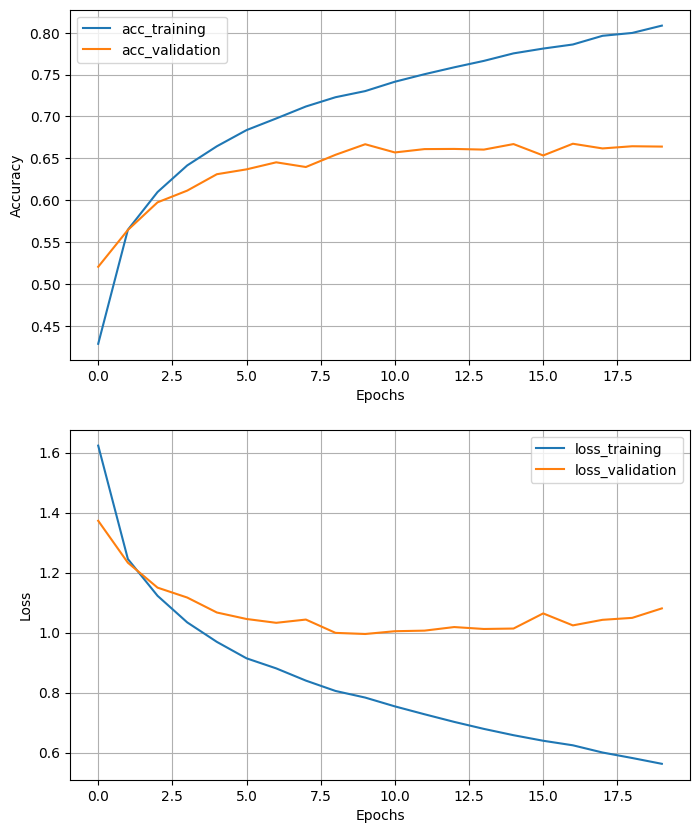

Test Loss: 1.05232334 ---------- Test Accuracy: 66.5500%


In [33]:
conv_filters = [32, 32]
kernel_sizes = [[3, 3], [3, 3]]
max_pool_sizes = [[1, 1], [2, 2]]
act_fs = [F.relu, F.relu]

num_epochs = 20
lr = 1e-3
new_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
                                    
#summary(new_model, input_size=(batch_size, 3, 32, 32))

print(new_model)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(new_model.parameters(), lr=lr)

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(new_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

test(new_model)


My_Convolutional_Network(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (max_pools): ModuleList(
    (0): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (1): MaxPool2d(kernel_size=[4, 4], stride=[4, 4], padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
epoch: 1 -> Accuracy: 33.56%, Loss: 1.85245466 ---------------- Val_Acc: 43.24%, Val_Loss: 1.61834872
epoch: 2 -> Accuracy: 45.54%, Loss: 1.53357911 ---------------- Val_Acc: 47.36%, Val_Loss: 1.49400198
epoch: 3 -> Accuracy: 49.54%, Loss: 1.43085396 ---------------- Val_Acc: 50.94%, Val_Loss: 1.41209543
epoch: 4 -> Accuracy: 52.18%, Loss: 1.36020875 ---------------- Val_Acc: 52.28%, Val_Loss: 1.37294424
epoch: 5 -> Accuracy: 54.22%, Loss: 1.30546975 ---------------- Val_Acc: 53.96%, Val_Loss: 1.32302880
e

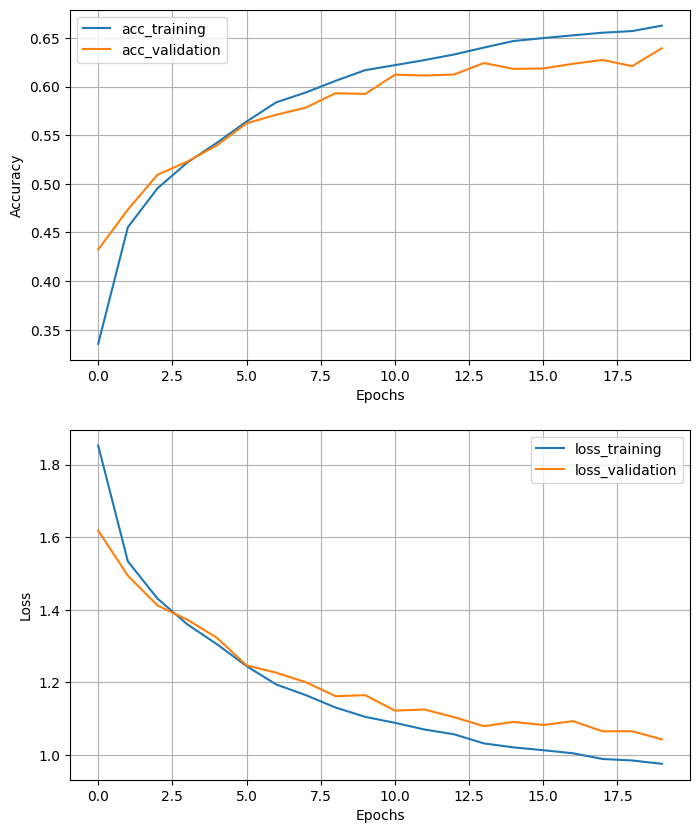

Test Loss: 1.02329075 ---------- Test Accuracy: 64.8100%


In [34]:
conv_filters = [32, 32]
kernel_sizes = [[3, 3], [3, 3]]
max_pool_sizes = [[2, 2], [4, 4]]
act_fs = [F.relu, F.relu]

num_epochs = 20
lr = 1e-3
new_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
                                    
#summary(new_model, input_size=(batch_size, 3, 32, 32))

print(new_model)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(new_model.parameters(), lr=lr)

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(new_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

test(new_model)


My_Convolutional_Network(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Conv2d(16, 16, kernel_size=(2, 2), stride=(1, 1), padding=same)
  )
  (max_pools): ModuleList(
    (0): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (1): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Linear(in_features=1024, out_features=10, bias=True)
)
epoch: 1 -> Accuracy: 33.42%, Loss: 1.88047171 ---------------- Val_Acc: 42.14%, Val_Loss: 1.65027523
epoch: 2 -> Accuracy: 45.23%, Loss: 1.55921078 ---------------- Val_Acc: 46.18%, Val_Loss: 1.53787935
epoch: 3 -> Accuracy: 49.42%, Loss: 1.44500446 ---------------- Val_Acc: 50.38%, Val_Loss: 1.42921436
epoch: 4 -> Accuracy: 52.69%, Loss: 1.35911584 ---------------- Val_Acc: 51.80%, Val_Loss: 1.36616802
epoch: 5 -> Accuracy: 54.88%, Loss: 1.29537034 ---------------- Val_Acc: 53.68%, Val_Loss: 1.31054735


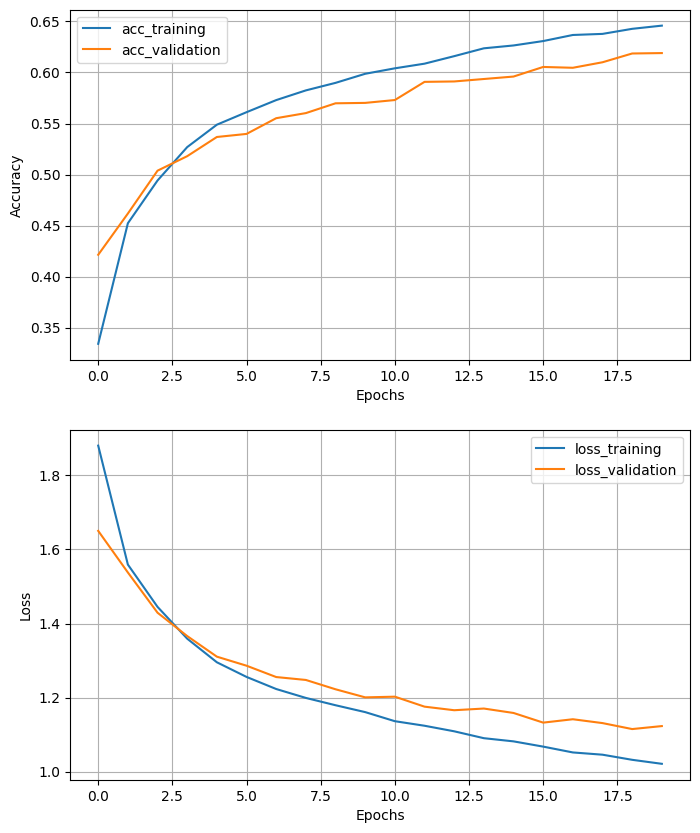

Test Loss: 1.09110141 ---------- Test Accuracy: 62.5300%


In [48]:
conv_filters = [16, 16]
kernel_sizes = [[3, 3], [2, 2]]
max_pool_sizes = [[2, 2], [2, 2]]
act_fs = [F.relu, F.relu]

num_epochs = 20
lr = 1e-3
new_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
                                    
#summary(new_model, input_size=(batch_size, 3, 32, 32))

print(new_model)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(new_model.parameters(), lr=lr)

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(new_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

test(new_model)

`%ENDTEXT`

# Transfer Learning with ResNet18 + ImageNet

Let's now experiment with transfer learning. We will now load the model structure and weights of a small [ResNet](https://en.wikipedia.org/wiki/Residual_neural_network) (which is still pretty big!), pretrained on the ImageNet dataset. We will then add a fully connected layer at the end of the network and fine-tune it on the CIFAR10 dataset. In this way, we can leverage the knowledge already present in the pre-trained weight and transfer it on our task!

In [35]:
from torchvision.models import resnet18, ResNet18_Weights

In [36]:
RESNET18 = resnet18(pretrained=True)
summary(RESNET18, input_size=(batch_size, 3, 32, 32))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [256, 1000]               --
├─Conv2d: 1-1                            [256, 64, 16, 16]         9,408
├─BatchNorm2d: 1-2                       [256, 64, 16, 16]         128
├─ReLU: 1-3                              [256, 64, 16, 16]         --
├─MaxPool2d: 1-4                         [256, 64, 8, 8]           --
├─Sequential: 1-5                        [256, 64, 8, 8]           --
│    └─BasicBlock: 2-1                   [256, 64, 8, 8]           --
│    │    └─Conv2d: 3-1                  [256, 64, 8, 8]           36,864
│    │    └─BatchNorm2d: 3-2             [256, 64, 8, 8]           128
│    │    └─ReLU: 3-3                    [256, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                  [256, 64, 8, 8]           36,864
│    │    └─BatchNorm2d: 3-5             [256, 64, 8, 8]           128
│    │    └─ReLU: 3-6                    [256, 64, 8, 8]           --
│

The ResNet has a final fully connected layer that generates 1000 logits corresponding to the classes in the ImageNet dataset. We will re-define it and make it map the features learned in the previous layer to the 10 classes of the CIFAR10 datset. 

In [37]:
linear_layer_input = RESNET18.fc.in_features
linear_layer_output = RESNET18.fc.out_features
print(f"Last layer: {linear_layer_input} -> {linear_layer_output}")

Last layer: 512 -> 1000


In [38]:
# Replace  the last layer
RESNET18.fc = Linear(linear_layer_input, 10)

In [39]:
linear_layer_input = RESNET18.fc.in_features
linear_layer_output = RESNET18.fc.out_features
print(f"Last layer: {linear_layer_input} -> {linear_layer_output}")

Last layer: 512 -> 10


Finally, we "freeze" the other weights in the network so that only the ones in the last layer are trainable.

In [40]:
for name, param in RESNET18.named_parameters():
    if name == 'fc.weight' or name == 'fc.bias':
      param.requires_grad = True
    else:
      param.requires_grad = False

In [41]:
RESNET18 = RESNET18.to(device) # Let's now load it to GPU

Let's consider a smaller subset of CIFAR10 in order to speed-up the fine-tuning process:

In [42]:
train_idxs = list(range(0, len(train_data), 5))  # 45000/5=9000 Tr
val_idxs = list(range(1, len(val_data), 5))  # 5000/5=1000 Val
test_idxs = list(range(1, len(test_data), 5))  # 10000/5=2000 Ts

train_data_sub = torch.utils.data.Subset(train_data, train_idxs)
val_data_sub = torch.utils.data.Subset(val_data, val_idxs)
test_data_sub = torch.utils.data.Subset(test_data, test_idxs)

In order to apply custom preprocessing steps that are expected by the pretrained model, we will define a small wrapper around the CIFAR10 dataset.

In [43]:
weights = ResNet18_Weights.DEFAULT
preprocess = weights.transforms()

class RESDatasetWrapper(Dataset):
  def __init__(self, dataset):
    self.dataset = dataset
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, idx):
    image, label = self.dataset[idx]
    image = preprocess(image)
    label = torch.tensor(label, dtype=torch.long)
    return image.to(device), label.to(device)

In [44]:
RES_train_dataset = RESDatasetWrapper(train_data_sub)
RES_val_dataset = RESDatasetWrapper(val_data_sub)
RES_test_dataset = RESDatasetWrapper(test_data_sub)

batch_size=256

RES_dataloader_training = DataLoader(RES_train_dataset, batch_size=batch_size, shuffle=True)
RES_dataloader_validation = DataLoader(RES_val_dataset, batch_size=batch_size)
RES_dataloader_test = DataLoader(RES_test_dataset, batch_size=batch_size)

In [45]:
num_epochs = 10
lr = 1e-3

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(RESNET18.parameters(), lr=lr)

In [46]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(RESNET18, optimizer,
                                                           RES_dataloader_training, 
                                                           RES_dataloader_validation,
                                                           epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 41.11%, Loss: 1.80519927 ---------------- Val_Acc: 60.50%, Val_Loss: 1.38273859
epoch: 2 -> Accuracy: 66.36%, Loss: 1.17357039 ---------------- Val_Acc: 68.60%, Val_Loss: 1.07232976
epoch: 3 -> Accuracy: 71.13%, Loss: 0.96386284 ---------------- Val_Acc: 68.80%, Val_Loss: 0.94679600
epoch: 4 -> Accuracy: 73.29%, Loss: 0.86399013 ---------------- Val_Acc: 70.50%, Val_Loss: 0.88210106
epoch: 5 -> Accuracy: 74.46%, Loss: 0.81079221 ---------------- Val_Acc: 71.30%, Val_Loss: 0.86094588
epoch: 6 -> Accuracy: 75.30%, Loss: 0.76885509 ---------------- Val_Acc: 71.30%, Val_Loss: 0.81426924
epoch: 7 -> Accuracy: 76.19%, Loss: 0.74121130 ---------------- Val_Acc: 71.90%, Val_Loss: 0.78776801
epoch: 8 -> Accuracy: 77.24%, Loss: 0.70604050 ---------------- Val_Acc: 73.40%, Val_Loss: 0.77493948
epoch: 9 -> Accuracy: 77.69%, Loss: 0.68641132 ---------------- Val_Acc: 72.00%, Val_Loss: 0.76775187
epoch: 10 -> Accuracy: 78.11%, Loss: 0.67585868 ---------------- Val_Acc: 72.30%, 

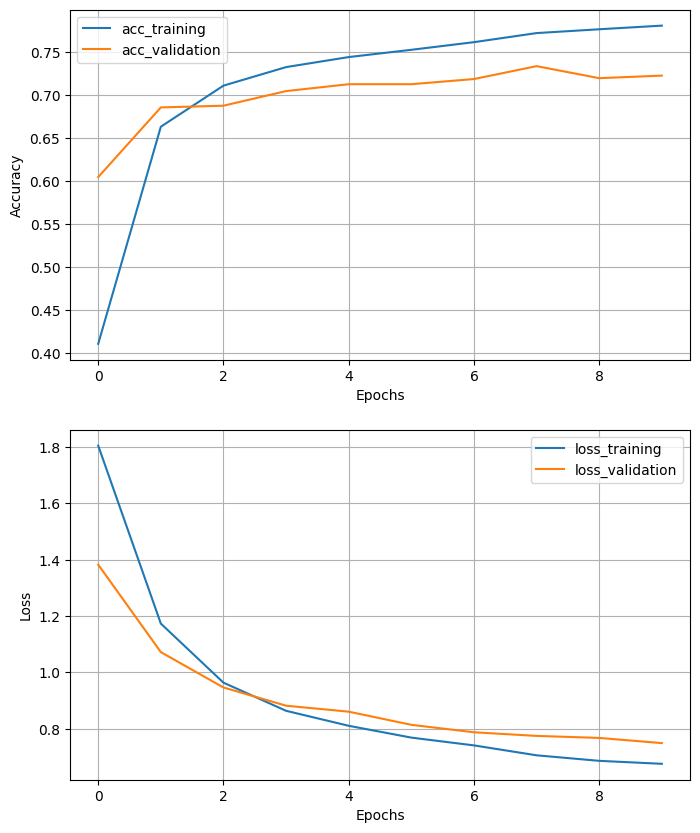

In [47]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [49]:
test(RESNET18, dataloader_test=RES_dataloader_test)

Test Loss: 0.75394034 ---------- Test Accuracy: 74.0500%


Notice how we got this result by leveraging a model freely available on the internet and trained on another dataset. That's the power of transfer learning! 